<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-the-Vadere-project" data-toc-modified-id="Load-the-Vadere-project-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load the Vadere project</a></span><ul class="toc-item"><li><span><a href="#Method-A-Plots" data-toc-modified-id="Method-A-Plots-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Method A Plots</a></span></li><li><span><a href="#Method-B-Plots" data-toc-modified-id="Method-B-Plots-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Method B Plots</a></span></li><li><span><a href="#Method-C-Plots-(classical-density)" data-toc-modified-id="Method-C-Plots-(classical-density)-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Method C Plots (classical density)</a></span></li><li><span><a href="#Method-E-Plots-(voronoi-density)" data-toc-modified-id="Method-E-Plots-(voronoi-density)-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Method E Plots (voronoi density)</a></span></li><li><span><a href="#Method-D-Plots-(voronoi-density)" data-toc-modified-id="Method-D-Plots-(voronoi-density)-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Method D Plots (voronoi density)</a></span></li></ul></li></ul></div>

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from vadereanalysistool import ScenarioOutput, VadereProject
from scipy.optimize import curve_fit

%matplotlib notebook

sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.0})

def plotEvolution(vproject, ending, yval, ylabel):
    plots = []
    i = 1
    plt.figure(1, figsize=(30, 10))
    for outStr in project.output_dirs :
        out = project.output_dirs[outStr]
        dataFrames = []
        for fileStr in out.files :
            if fileStr.endswith(ending) :
                ndf = pd.DataFrame();
                df = out.files[fileStr]()
                #df = df[df.velocity > 0]
                ndf['density'] = df.density.astype(float)
                ndf['velocity'] = df.velocity.astype(float)
                ndf['timeStep'] = df.timeStep.astype(int)
                ndf['scenario'] = [out.scenario['name']] * len(df.density)
                dataFrames.append(ndf)
            #concatFrames = pd.concat(dataFrames)
        plt.subplot(2, 1, i)
        plt.title(out.scenario['name'])
        plt.xlabel('timeStep')
        plt.ylabel(ylabel)
        sns.lineplot(x='timeStep', y=yval, data=pd.concat(dataFrames))
        i = i + 1

def plotFundamentalDiagram(vproject, ending):
    dataFrames = []
    for outStr in project.output_dirs :
        out = project.output_dirs[outStr]
        for fileStr in out.files :
            if fileStr.endswith(ending) :
                ndf = pd.DataFrame();
                df = out.files[fileStr]()
                ndf['density'] = df.density.astype(float)
                ndf['velocity'] = df.velocity.astype(float)
                ndf['scenario'] = [outStr] * len(df.velocity)
                ndf = ndf[(ndf.velocity > 0) & (ndf.density < 10)]
                ndf = ndf.iloc[::16, :]
                dataFrames.append(ndf)
    concatFrames = pd.concat(dataFrames)
    g = sns.relplot(x="density", y="velocity", hue="scenario", data=concatFrames,
                height=10, aspect=1)
    g.set(
        xticks=np.arange(0, np.min([np.floor(np.max(concatFrames['density'])) + 1, 10]), 1), 
        yticks=np.arange(0, np.floor(np.max(concatFrames['velocity'])) + 1, 0.5)
    );
    #axis = g.axes
    #axes.set_xticks([0,1,2,3,4,5,6])
    #axes.set_yticks([0,0.5,1,1.5,2,2.5])
    #axes.set_xlim(0,6)
    #axes.set_ylim(0,2.5)
    
def plotFundamentalDiagramScatter(vproject, ending, sep=False, width = 10, height = 5):
    dataFrames = []
    index = 0
    cols = 3
    rows = len(vproject.output_dirs) / cols + 1
    if not sep :
        fig, axs = plt.subplots(int(rows), int(cols), figsize=(height*rows, width*cols), sharex=False, sharey=True)       
    for outStr in vproject.output_dirs :
        out = vproject.output_dirs[outStr]
        for fileStr in out.files :
            if fileStr.endswith(ending) :
                if not sep : 
                    axes = axs[int(index / cols), int(index % cols)]
                else :
                    fig = plt.figure(1, figsize=(width, height))
                    axes = plt.axes()
                    fig.add_axes(axes)
                ndf = pd.DataFrame();
                df = out.files[fileStr]()
                ndf['density'] = df.density.astype(float)
                ndf['velocity'] = df.velocity.astype(float)
                ndf['scenario'] = [out.scenario['name']] * len(df.velocity)
                #ndf = ndf[ndf.density < 7]
                #plt.scatter()
                #axes.set_title(out.scenario['name'])
                axes.set_xlabel('density')
                axes.set_ylabel('velocity')
                axes.set_xticks(np.arange(0, np.floor(np.max(ndf['density'])) + 1, 1))
                axes.set_yticks(np.arange(0, np.floor(np.max(ndf['velocity'])) + 1, 0.5))
                axes.set_xlim(0,np.floor(np.max(ndf['density'])) + 1)
                axes.set_ylim(0,np.floor(np.max(ndf['velocity'])) + 1)
                axes.scatter(ndf['density'], ndf['velocity'], s=0.7, marker='*', color='#555555')
                wm = plotWeidmann(axes)
                popt, pcov = curve_fit(kladek, ndf['density'], ndf['velocity'], p0=(1.34, 1.913, 5.4))
                print(str(popt[0]) + "," + str(popt[1]) + "," + str(popt[2]))
                xx = np.linspace(0.1, np.floor(np.max(ndf['density'])) + 1, 1000)
                yy = kladek(xx, *popt)
                axes.plot(xx, yy, '--', c=sns.color_palette().as_hex()[1])     
                axes.legend(['Weidmann', 'regression', 'Simulated data'])
                index = index + 1;
                if sep :
                    fig.savefig("./"+out.scenario['name']+"_fundamental_diagram"+".png", bbox_inches='tight')
                    plt.show()
    if not sep :
        fig.savefig("./"+vproject.project_name+"_fundamental_diagrams"+".png", bbox_inches='tight')
        

# Load the Vadere project

In [2]:
projectFolder = "./../../../VadereModelTests/TestCWL/"
project = VadereProject(projectFolder)
#out = project.named_output.C_050_180_180_2018_11_26_16_30_29_355() 

loaded 7 out of 7 output directories. 


## Method A Plots

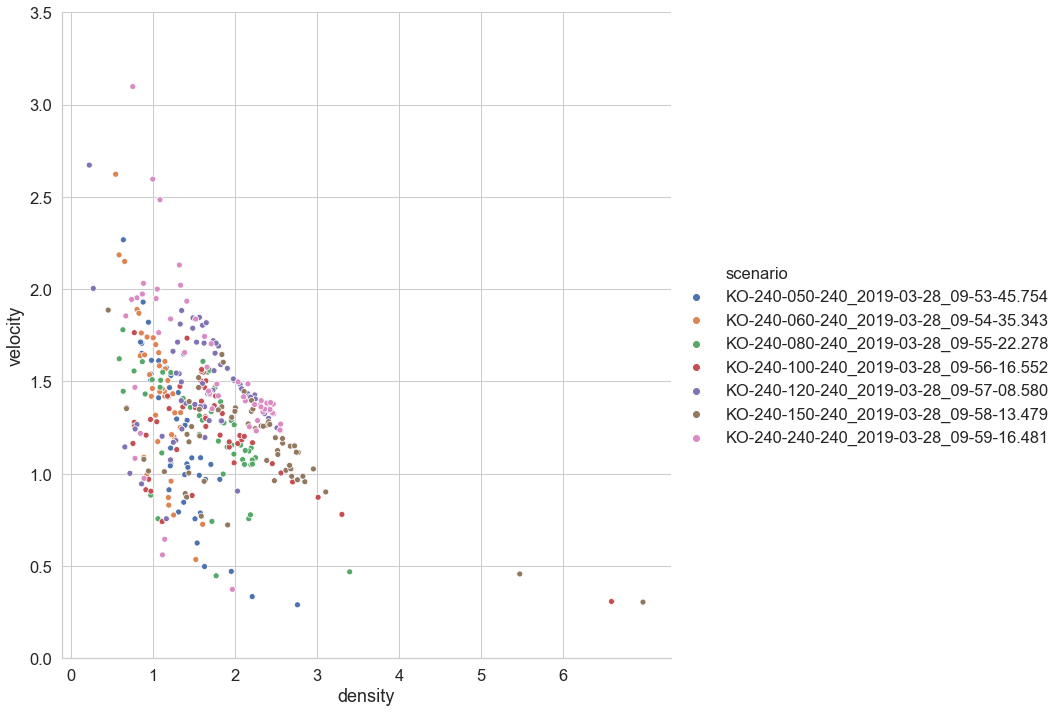

In [8]:
# transform data frame
%matplotlib inline
plotFundamentalDiagram(project, "aTimeStep.fundamentalDiagram")

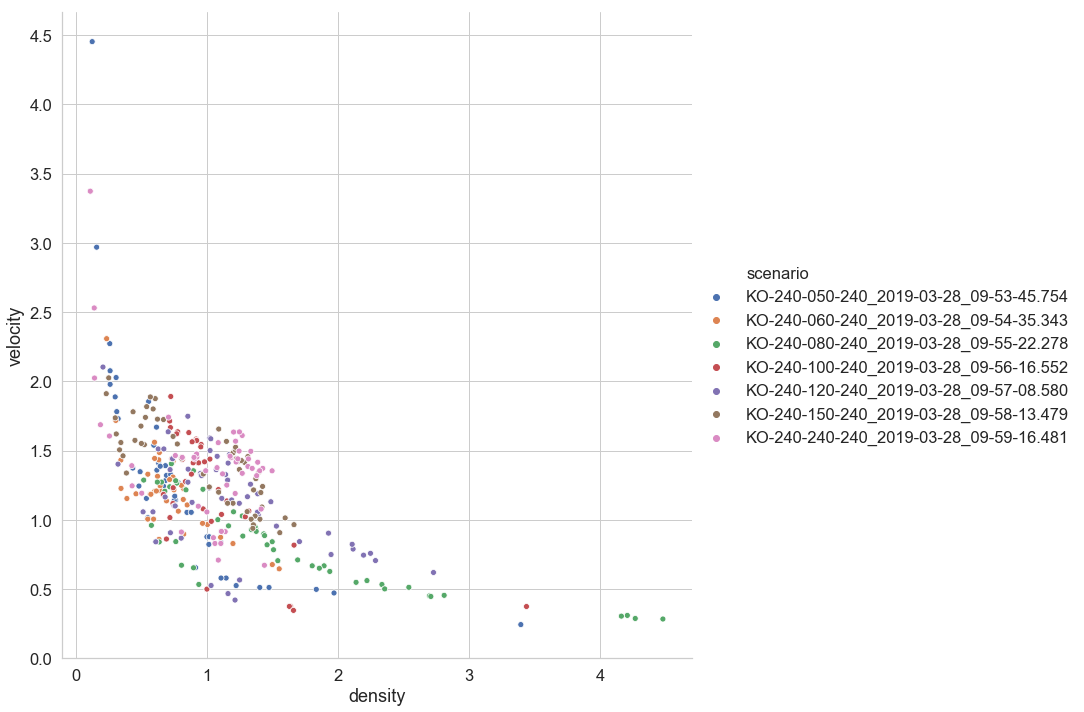

In [9]:
# transform data frame
%matplotlib inline
plotFundamentalDiagram(project, "aTimeStep_left.fundamentalDiagram")

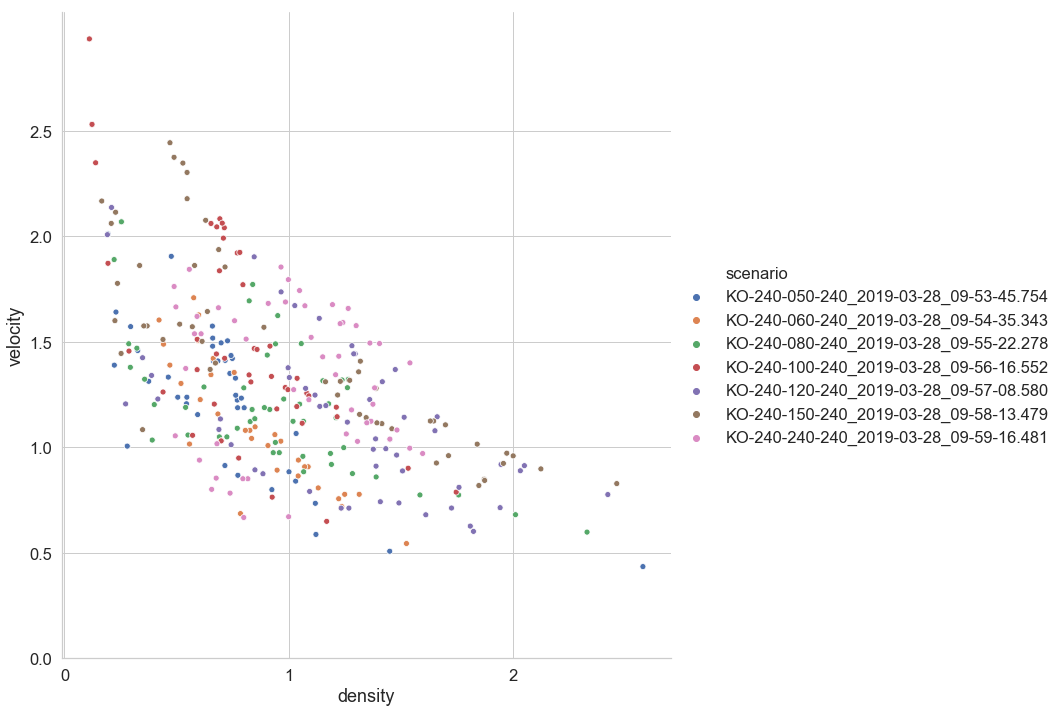

In [10]:
# transform data frame
%matplotlib inline
plotFundamentalDiagram(project, "aTimeStep_right.fundamentalDiagram")

## Method B Plots

In [ ]:
plotFundamentalDiagram(project, "bPedestrian.fundamentalDiagram")

## Method C Plots (classical density)

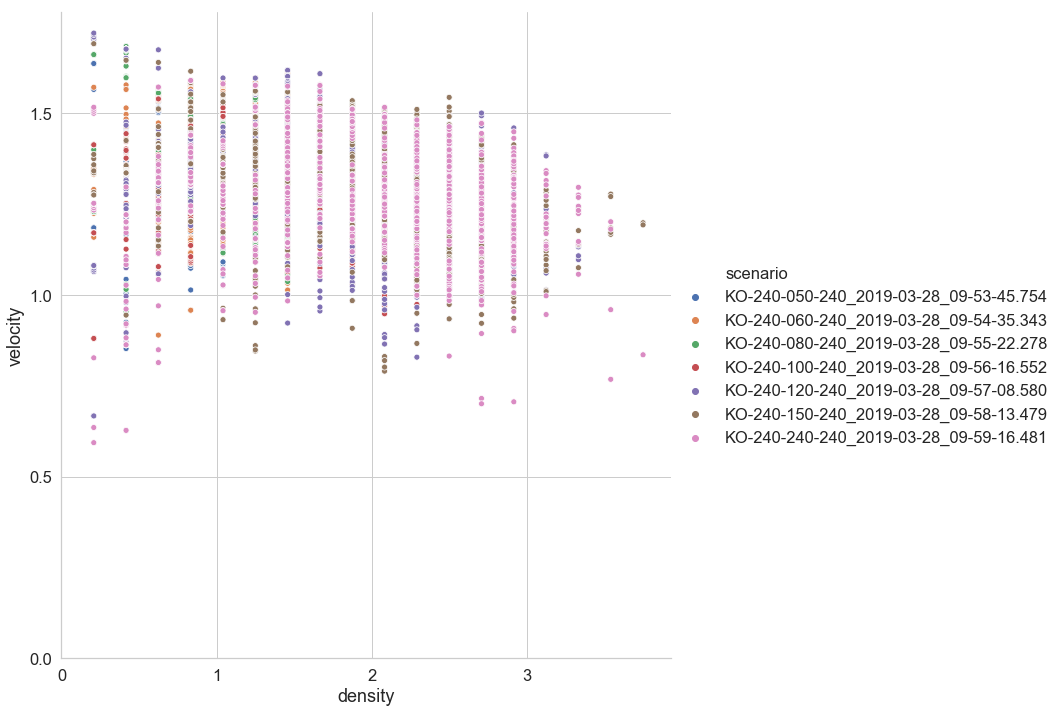

In [6]:
plotFundamentalDiagram(project, "cTimeStep.fundamentalDiagram")

## Method E Plots (voronoi density)

In [ ]:
plotFundamentalDiagram(project, "eTimeStep.fundamentalDiagram")

## Method D Plots (voronoi density)

In [ ]:
plotFundamentalDiagram(project, "dTimeStep.fundamentalDiagram")

In [ ]:
np.linspace(0, 200, num=201).tolist()

In [ ]:
import matplotlib.pyplot as plt

coord1 = [[23.926582253991363,11.311616564587455],[24.526824188631515,11.346725287186784],[24.52439283212948,11.89],[23.80719398422859,11.89]]
coord1.append(coord1[0])
coord2 = [[22.0,10.1], [24.0,10.1], [24.0,11.9], [22.0,11.9], [22.0,10.1]]
coord2.append(coord2[0])
cap = [[23.926582253991363,11.311616564587455],[24.000000000000014,11.315910838495633],[24.000000000000025,11.889999999999956],[23.80719398422859,11.89]]
cap.append(cap[0])

xs1, ys1 = zip(*coord1) #create lists of x and y values
xs2, ys2 = zip(*coord2) 
xs3, ys3 = zip(*cap) 
plt.figure(figsize=(10,10))
plt.plot(xs1,ys1)
plt.plot(xs2,ys2)
plt.plot(xs3,ys3)
plt.show() # if you need...


In [ ]:
import matplotlib.pyplot as plt

coord = [[1,1], [2,1], [2,2], [1,2], [0.5,1.5]]
coord.append(coord[0]) #repeat the first point to create a 'closed loop'

xs, ys = zip(*coord) #create lists of x and y values

plt.figure()
plt.plot(xs,ys) 
plt.show() # if you need..